In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
import cv2 as cv
import torchlayers as tl
import os

In [2]:
trans = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trans_gray = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor(), transforms.Grayscale(3)])


# data = torchvision.datasets.ImageFolder(root = './data/tiny-imagenet-200/train', transform = trans)
# train_size = int(len(data) * 0.8)
# val_size = len(data) - train_size
# train_sets, test_sets = torch.utils.data.random_split(data, [train_size, test_size])

# edge_datas = torchvision.datasets.ImageFolder(root = './data/kcar_edge/darks', transform = trans_gray)
# edge_train_size = int(len(edge_datas) * 0.8)
# edge_test_size = len(edge_datas) - edge_train_size
# edge_train_sets, edge_test_sets = torch.utils.data.random_split(edge_datas, [edge_train_size, edge_test_size])

# edge_train_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans)
# edge_test_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/darks', transform = trans)
train_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_train', transform = trans)
val_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_val', transform = trans)
test_sets = torchvision.datasets.ImageFolder(root = './data/cifar100_test', transform = trans)
labels = test_sets.classes
# print(len(edge_train_sets))
# print(len(edge_test_sets))
print(len(train_sets))
print(len(test_sets))
print(len(labels))
# print(test_sets)
# print(edge_test_sets)

# print(len(labels))
# for i in range(4):
#     img, label = train_sets[i]
#     print(labels[label])
#     plt.subplot(241 + i)
#     plt.imshow(np.clip(img.permute(1,2,0),0,1))
#     plt.tight_layout()
#     plt.show()
#     save_image(img, str(i)+'_.jpg')


40000
10000
100


In [3]:
# DataLoader 정의 - data 길이 달라지면 random_t_list 수정하기!
import random

random_train_list = list(range(1, len(train_sets)))
random.shuffle(random_train_list)
random_val_list = list(range(1, len(val_sets)))
random.shuffle(random_val_list)
random_test_list = list(range(1, len(test_sets)))
random.shuffle(random_test_list)

train_loader = DataLoader(train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
val_loader = DataLoader(val_sets, batch_size = 32, num_workers = 2, sampler = random_val_list)
# edge_train_loader = DataLoader(edge_train_sets, batch_size = 32, num_workers = 2, sampler = random_train_list)
print(len(train_loader), len(val_loader))
test_loader = DataLoader(test_sets, batch_size = 32, sampler = random_test_list)
# test_loader_dark = DataLoader(test_sets, batch_size = 32, sampler = random_test_list)
# edge_test_loader = DataLoader(edge_test_sets, batch_size = 32, sampler = random_test_list)

1250 313


In [4]:
len(val_sets)

10000

In [5]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
 
        _, pred = output.topk(maxk, 1, True, True) #(52, 32)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # (5,32)
 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [6]:
import wget
# wget.download("https://storage.googleapis.com/bit_models/BiT-M-R101x1.npz")

In [7]:
# resnet101 = torchvision.models.resnet101(pretrained=True)
# resnet101 = resnet101.cuda()
BLOCK_UNITS = {
    'r50': [3, 4, 6, 3],
    'r101': [3, 4, 23, 3],
    'r152': [3, 8, 36, 3],
}

# from big_transfer_master.bit_pytorch.models import ResNetV2
# resnet101 = ResNetV2(BLOCK_UNITS["r101"], width_factor=1, zero_head=False)
# resnet101.load_from(np.load("BiT-M-R101x1.npz"))

resnet101 = torchvision.models.resnet101(pretrained=False)
# for param in resnet101.parameters():
#     param.requires_grad = False
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default
# resnet101.fc = nn.Linear(1000, 100) # assuming that the fc7 layer has 512 neurons, otherwise change it 
feat_num = resnet101.fc.in_features
resnet101.fc = nn.Linear(feat_num, 100)
resnet101.cuda()
print("created model")

created model


In [9]:
#모델 학습
# from sam import SAMSGD

# optimizer = SAMSGD(resnet101.parameters(), lr=1e-1, rho=0.05)

print(len(train_loader))
print(len(val_loader))

criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet101.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,8], gamma=0.1)

learning_rate = 1e-4
optimizer = optim.Adam(resnet101.parameters(), lr=learning_rate)

# hyper-parameters
num_epochs = 20
num_batches = 32

resnet101.train()
max_acc = 30
saved_trn_acc = 0

trn_loss_list = []
val_loss_list = []
val_loss_list_dark = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    total = 1 ##TODO : change to 0
    correct = 1
    for i, data in enumerate(train_loader):
        x, label = data
        x = x.cuda()
        label = label.cuda()
        #grad init
        optimizer.zero_grad()
        #forward propagation
        model_output = resnet101(x)               
        _, predicted = torch.max(model_output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        # def closure():
        #     optimizer.zero_grad()
        #     model_output = resnet101(x)               
        #     _, predicted = torch.max(model_output.data, 1)
        #     total = label.size(0)
        #     correct = (predicted == label).sum().item()
        #     loss = criterion(model_output, label)
        #     loss.backward()
        #     return loss


        # loss = optimizer.step(closure)
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        
        # 학습과정 출력
        if (i+1) % 100 == 1: # every 100 mini-batches
            resnet101.eval()
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                val_total = 0
                val_correct = 0
                val_total_dark = 0
                val_correct_dark = 0
                
                count = 0
                for j, (val) in enumerate(val_loader):
                    count += 1
                    val_x, val_label = val
                    val_x = val_x.cuda()
                    val_label =val_label.cuda()

                    val_output = resnet101(val_x)
                    _, predicted = torch.max(val_output.data, 1)
                    val_total += val_label.size(0)
                    val_correct += (predicted == val_label).sum().item()
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    if count > 0 and ((100 * val_correct / val_total) < max_acc - 3) :
                        break
                print('{}: train: {:.4f}%, val: {:.4f}%'.format(j * len(val_loader), (100 * correct / total), (100 * val_correct / val_total)))
                if (100 * val_correct / val_total) > max_acc:
                    max_acc = (100 * val_correct / val_total)
                    saved_trn_acc = (100 * val_correct / val_total)
                    MODEL = "false_one_way_resnet101"
                    path = "./models/"
                    torch.save(resnet101, f'{path}_{MODEL}_{(100 * val_correct / val_total):.4f}_epoch_{epoch}.pt')
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, len(train_loader), trn_loss / total, val_loss / val_total))
            print("-----------------max accuracy : {:.4f}, train acc : {:.4f}--------------".format(max_acc, saved_trn_acc))
                    
            
            trn_loss_list.append(trn_loss/total)
            val_loss_list.append(val_loss/val_total)
            trn_loss = 0.0
            resnet101.train()
        
        # del (memory issue)
        # del lossadw
                                                                                                                        # del model_output
   # scheduler.step()
#plotting the loss chart 

1250
313
97656: train: 54.5455%, val: 31.9432%
epoch: 1/20 | step: 1/1250 | trn loss: 0.0527 | val loss: 0.1069
-----------------max accuracy : 31.9432, train acc : 31.9432--------------
313: train: 71.5435%, val: 28.1250%
epoch: 1/20 | step: 101/1250 | trn loss: 0.0298 | val loss: 0.1127
-----------------max accuracy : 31.9432, train acc : 31.9432--------------
626: train: 78.0973%, val: 27.0833%
epoch: 1/20 | step: 201/1250 | trn loss: 0.0091 | val loss: 0.1089
-----------------max accuracy : 31.9432, train acc : 31.9432--------------
97656: train: 80.8367%, val: 31.3631%
epoch: 1/20 | step: 301/1250 | trn loss: 0.0054 | val loss: 0.1088
-----------------max accuracy : 31.9432, train acc : 31.9432--------------
313: train: 82.4437%, val: 23.4375%
epoch: 1/20 | step: 401/1250 | trn loss: 0.0036 | val loss: 0.1183
-----------------max accuracy : 31.9432, train acc : 31.9432--------------
0: train: 83.8146%, val: 15.6250%
epoch: 1/20 | step: 501/1250 | trn loss: 0.0026 | val loss: 0.132

KeyboardInterrupt: 

In [10]:
torch.save(resnet101, 'resnet_tmp.pt')

In [13]:
resnet101 = torch.load('_one_way_resnet101_31.9432_epoch_0.pt')

In [14]:
resnet101.eval()
with torch.no_grad(): # very very very very important!!!
    
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    for j, (val) in enumerate(test_loader):
        val_x, val_label = val
        val_x = val_x.cuda()
        val_label =val_label.cuda()
        val_output = resnet101(val_x)
        _, predicted = torch.max(val_output.data, 1)
        val_total += val_label.size(0)
        val_correct += (predicted == val_label).sum().item()
        v_loss = criterion(val_output, val_label)
        val_loss += v_loss
        # acc1, acc5 = accuracy(val_output, val_label, topk=(1, 5))
        # print("test acc1 : {}, acc5 : {}".format(acc1[0], acc5[0]))
    print("----------------testing data: "+ str(j * len(test_loader)))
    print('Accuracy of the network on the test images: %f %%' % (100 * val_correct / val_total))
                       

----------------testing data: 97656
Accuracy of the network on the test images: 32.893289 %


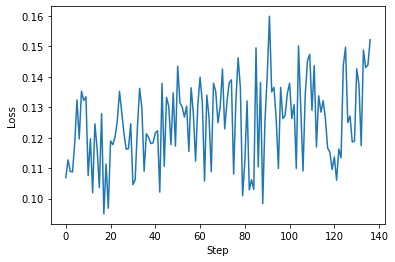

In [17]:
val = []
for l in val_loss_list:
    val.append(l.cpu())
plt.plot(val)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

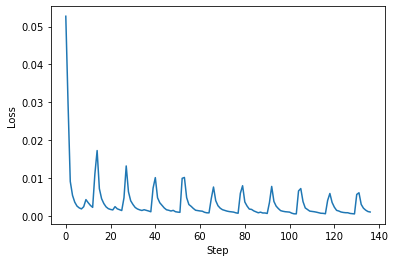

In [16]:
plt.plot(trn_loss_list)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()